## Setup

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.8MB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
     |████████████████████████████████| 1.0MB 9.0MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 358kB 16.5MB/s 
     |████████████████████████████████| 92kB 7.9MB/s 
     |████████████████████████████████| 40kB 4.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 2.6MB 20.3MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '5800ccc8024c48db9b47ad61ab9a1f60')
categories = 'cauliflower_plant','cabbage_plant','brussels_sprout_plant','kohlrabi_plant','kale_plant','broccoli_plant','brassicaceae_plant'
path = Path('categories')

## Download data

In [4]:
if not path.exists():
    path.mkdir()
    for category in categories:
        dest = (path/category)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{category}')
        download_images(dest, urls=results.attrgot('content_url'))

In [5]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

## Load data

In [6]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

data_block = data_block.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
)

dls = data_block.dataloaders(path)

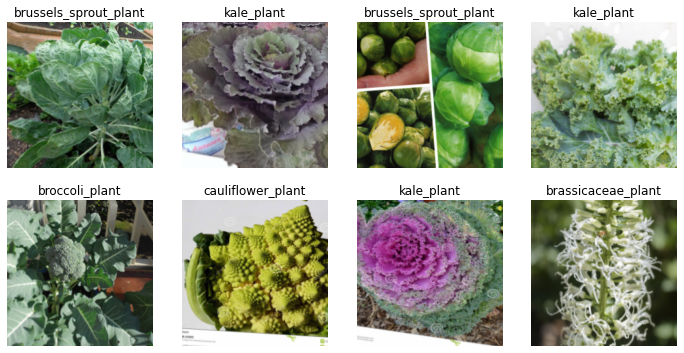

In [7]:
dls.train.show_batch(max_n=8, nrows=2, unique=False)

## Training


In [8]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Confusion

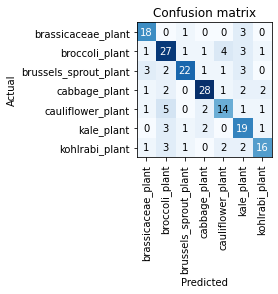

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

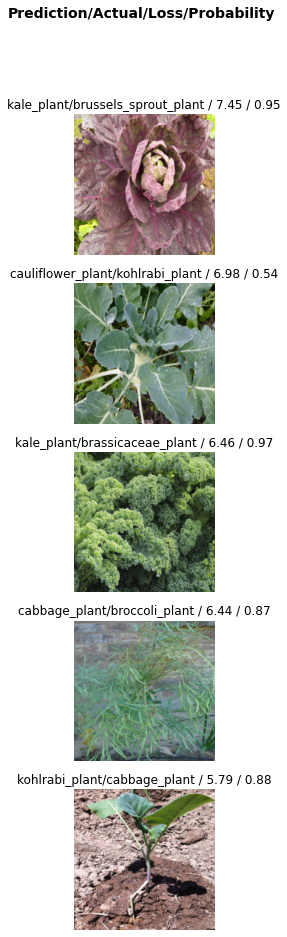

In [13]:
interp.plot_top_losses(5, nrows=5)

### Cleaning

In [11]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()

for idx,cat in cleaner.change():
  filepath = str(cleaner.fns[idx])
  filename = "_" + os.path.basename(str(cleaner.fns[idx]))
  destpath = path/cat/filename
  print("move", filepath, "to", destpath)
  shutil.move(filepath, destpath)

## Predictions

In [15]:
btn_upload = widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

In [16]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [17]:
learn.predict(img)

('brassicaceae_plant',
 tensor(0),
 tensor([6.6689e-01, 3.0543e-04, 5.1163e-05, 4.3557e-03, 3.1186e-04, 1.5245e-02, 3.1284e-01]))

## Export

In [18]:
learn.export()